<div class='bar_title'></div>

*Practical Data Science*

# Advanced Training and Regularization

Matthias Griebel<br>
Chair of Information Systems and Management

Winter Semester 19/20

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Advanced-Training-(Assignment-4)" data-toc-modified-id="Advanced-Training-(Assignment-4)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Advanced Training (Assignment 4)</a></span><ul class="toc-item"><li><span><a href="#Introduction-and-Dataset" data-toc-modified-id="Introduction-and-Dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction and Dataset</a></span></li><li><span><a href="#Creating-the-DataBunch" data-toc-modified-id="Creating-the-DataBunch-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Creating the DataBunch</a></span></li><li><span><a href="#Train-the-Model" data-toc-modified-id="Train-the-Model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Train the Model</a></span><ul class="toc-item"><li><span><a href="#Changing-image-size" data-toc-modified-id="Changing-image-size-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Changing image size</a></span></li><li><span><a href="#Mixed-precision-training" data-toc-modified-id="Mixed-precision-training-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Mixed precision training</a></span></li></ul></li><li><span><a href="#Result-Interpretation" data-toc-modified-id="Result-Interpretation-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Result Interpretation</a></span></li></ul></li><li><span><a href="#Regularization" data-toc-modified-id="Regularization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regularization</a></span><ul class="toc-item"><li><span><a href="#Bias–variance-tradeoff" data-toc-modified-id="Bias–variance-tradeoff-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Bias–variance tradeoff</a></span></li><li><span><a href="#Early-Stopping" data-toc-modified-id="Early-Stopping-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Early Stopping</a></span></li><li><span><a href="#Dropout" data-toc-modified-id="Dropout-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Dropout</a></span></li><li><span><a href="#Batch-Normalization" data-toc-modified-id="Batch-Normalization-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Batch Normalization</a></span></li><li><span><a href="#Weight-Decay" data-toc-modified-id="Weight-Decay-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Weight Decay</a></span></li><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Data Augmentation</a></span><ul class="toc-item"><li><span><a href="#Stanford-Cars-Example" data-toc-modified-id="Stanford-Cars-Example-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Stanford Cars Example</a></span></li></ul></li></ul></li></ul></div>

__Credits__

- Fast.ai lesson 6: https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb
- https://github.com/hiromis/notes/blob/master/Lesson5.md
- https://github.com/hiromis/notes/blob/master/Lesson6.md
- https://docs.fast.ai/
- https://www.fast.ai/2018/07/02/adam-weight-decay/

## Advanced Training (Assignment 4)

### Introduction and Dataset

The [Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) by [Krause, Jonathan, et al., 2013](https://www.cv-foundation.org//openaccess/content_iccv_workshops_2013/W19/papers/Krause_3D_Object_Representations_2013_ICCV_paper.pdf) contains 16,185 images of 196 classes of cars. 

The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

![Example Car](https://ai.stanford.edu/~jkrause/cars/car4.jpg)

In [21]:
from fastai.vision import *
from scipy.io import loadmat #this package is used to load matlab files

In [22]:
# If necassary, download and store the data.
# !wget 'http://imagenet.stanford.edu/internal/car196/car_ims.tgz'
# !wget 'http://imagenet.stanford.edu/internal/car196/cars_annos.mat'
# !tar -xf car_ims.tgz

All images of this data set are stored in the `car_ims`directory. List the first 10 image files in this directory.

In [0]:
path_img = 'car_ims'
fnames = get_image_files(path_img)
fnames[:10]

[PosixPath('car_ims/001935.jpg'),
 PosixPath('car_ims/000107.jpg'),
 PosixPath('car_ims/011016.jpg'),
 PosixPath('car_ims/015240.jpg'),
 PosixPath('car_ims/012143.jpg'),
 PosixPath('car_ims/000568.jpg'),
 PosixPath('car_ims/005503.jpg'),
 PosixPath('car_ims/003426.jpg'),
 PosixPath('car_ims/005347.jpg'),
 PosixPath('car_ims/014361.jpg')]

Different data sets are labeled in many different ways. The images of this data set are stored in only one directory with their `id` as file name. The labels are stored in a different file called 'cars_annos.mat'. You can use the following code block to load this file into a DataFrame.

In [23]:
# Create Labels from class names
cars_annos = loadmat('cars_annos.mat')
class_names = cars_annos['class_names']
labels = [c for c in class_names[0]]
labels = pd.DataFrame(labels, columns=['labels'])
labels['class'] = labels.index+1
# Create Data Frame from .mat file
frame = [[i.flat[0] for i in line] for line in cars_annos['annotations'][0]]
columns = [ 'fname','bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class','test']
df = pd.DataFrame(frame, columns=columns)
df = df.merge(labels, on='class')
df.head()

fname  bbox_x1  bbox_y1  bbox_x2  bbox_y2  class  test  \
0  car_ims/000001.jpg      112        7      853      717      1     0   
1  car_ims/000002.jpg       48       24      441      202      1     0   
2  car_ims/000003.jpg        7        4      277      180      1     0   
3  car_ims/000004.jpg       33       50      197      150      1     0   
4  car_ims/000005.jpg        5        8       83       58      1     0   

                       labels  
0  AM General Hummer SUV 2000  
1  AM General Hummer SUV 2000  
2  AM General Hummer SUV 2000  
3  AM General Hummer SUV 2000  
4  AM General Hummer SUV 2000

For now, we only want to work with the train set of the data, i.e, the files where the column `test` is 0. Filter the DataFrame `df` accordingly and save it as `df_train`. 

In [24]:
df_train = df[df.test == 0]

### Creating the DataBunch

Fast.ai expects the data to be loaded as a Data Bunch. Use the [data block API](https://docs.fast.ai/data_block.html) to 
1. load the data using `df_train` ([from_df](https://docs.fast.ai/vision.data.html#ImageList.from_df))
2. split the images randomly into 85% train and 15% test set ([docs](https://docs.fast.ai/data_block.html#Step-2:-Split-the-data-between-the-training-and-the-validation-set), use seed = 0)
3. label the inputs using the column 'labels' in the DataFrame

Note: If a function requires a `path` argument, set `path=""`.

In [25]:
src = (ImageList.from_df(df_train, path="", cols='fname')
                .split_by_rand_pct(valid_pct=0.15, seed=0)
                .label_from_df('labels'))

4. apply the [default fast.ai transforms](https://docs.fast.ai/vision.transform.html#get_transforms) and crop the images to a size of 224x224 pixel.
5. create a DataBunch with a batch size of 64
6. normalize the data to the imagenet statistics

In [26]:
data = (src.transform(get_transforms(), size=224)
            .databunch(bs=64)
            .normalize(imagenet_stats))

Now, use the DataBunch to display three rows of random pictures from a batch.

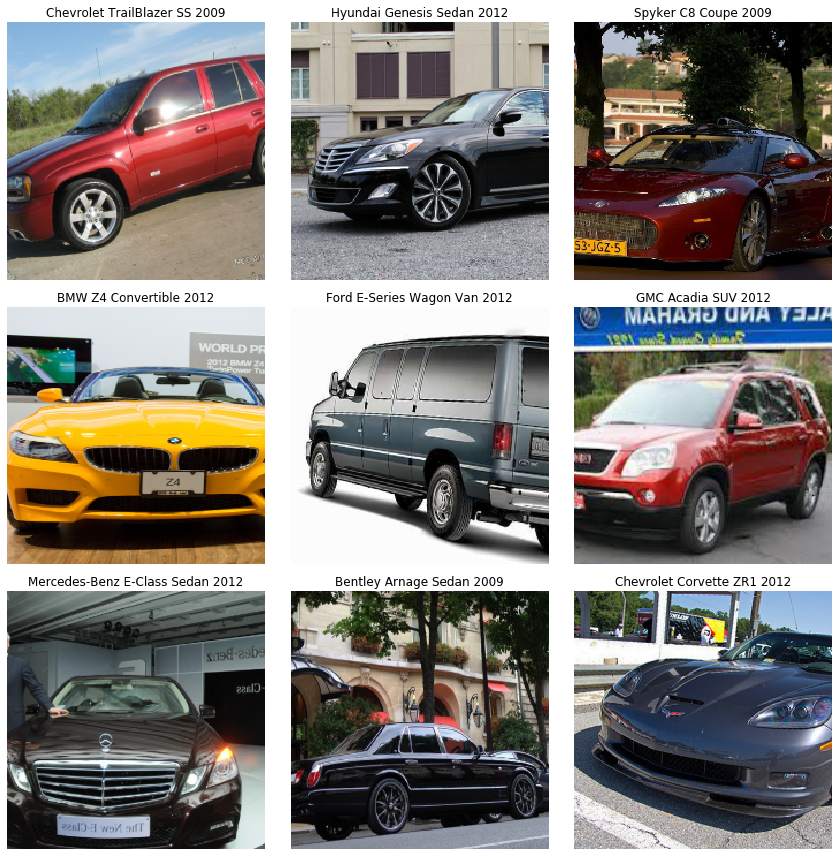

In [27]:
data.show_batch(3)

The data set description states that there are 196 vehicle classes in the data set. Verify this statement using the data stored in the DataBunch.

In [0]:
# Write your code here
len(data.classes) == 196

True

### Train the Model

Once the data is ready you can start training a model. Use the `cnn_learner` to create a model with 
- a Resnet34 architecture
- the metrics *accuracy* and [*top-5 accuracy*](https://docs.fast.ai/metrics.html#top_k_accuracy)

In [28]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, top_k_accuracy])

Finally, you can train the model. Apply the concepts from the lecture, i.e., 
- finding the learning rate
- training the last layers
- unfreezing the model
- train all layers (learning rate rule of thumb!)

Always provide an explanation **why** you chose the number of epochs and the learning rate.

Save the model after each training 
```
learn.save('stage-x')
``` 
so that you can reload the model 
``` 
learn = learn.load('stage-x')
``` 
if something goes wrong. If you load a model with *freezed* layers, you need to *unfreeze* the layers again.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 4.79E-03


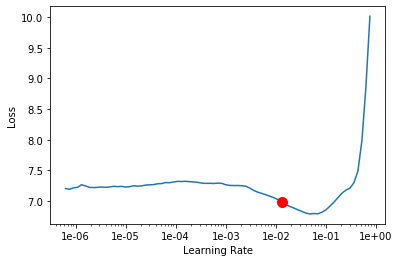

In [29]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [30]:
# Fit the model with the suggested learning rate
learn.fit_one_cycle(10, max_lr=1e-2)

In [31]:
learn.save('stage1-224')

In [32]:
# Since our model is working as we expect it to, we will unfreeze our 
# model and train some more.
learn.unfreeze()

In [33]:
# The basic rule of thumb is after you unfreeze (i.e. train the whole thing),
# pass a max learning rate parameter, pass it a slice, make the second 
# part of that slice about 10 times smaller than your first stage.
learn.fit_one_cycle(10, slice(1e-6, 5e-5))

In [34]:
learn.save('stage2-224')

#### Changing image size

Sometime, increasing the input size of the images can improve the model performance. Let's give it a try:

In [35]:
data = (src.transform(get_transforms(), size=352)
            .databunch(bs=64)
            .normalize(imagenet_stats))
learn.data = data

In [39]:
learn.freeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


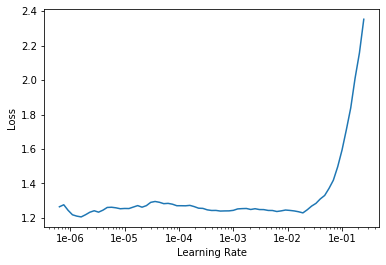

In [40]:
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(5, 1e-4)

In [42]:
learn.save('stage1-352')

Unfreeze and train some more...

In [99]:
learn.unfreeze()

In [44]:
learn.fit_one_cycle(10, slice(1e-6, 5e-5))

In [45]:
learn.save('stage2-352')

... and we could still go on!

#### Mixed precision training

The `to_fp16` [module](https://docs.fast.ai/callbacks.fp16.html#to_fp16) allows the forward and backward passes of your neural net to be done in fp16 (also known as half precision).

- You can use larger batch sizes
- Sometimes it also improves generalization
- If you have an NVIDIA GPU with tensor cores, it can speed up your training by __200% or more__.

In [112]:
data = (src.transform(get_transforms(), size=352)
            .databunch(bs=128)
            .normalize(imagenet_stats))
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, top_k_accuracy]).to_fp16()

In [113]:
learn.load('stage1-352')
learn.unfreeze()

In [106]:
learn.fit_one_cycle(1, slice(1e-6, 5e-5))

No time improvement here!

If we're running out of memory, we can use `gc.collect()` to run a full collection and free memory space:

In [103]:
import gc
gc.collect()

7181

`gc` exposes the underlying memory management mechanism of Python, the automatic garbage collector. The module includes functions for controlling how the collector operates and to examine the objects known to the system, either pending collection or stuck in reference cycles and unable to be freed.

### Result Interpretation






Explain the difference betweeen the metrics *accuracy* and *top_5_accuracy*. Why can it be useful to report both metrics?

> Top-1 accuracy is the conventional accuracy: the model answer (the one with highest probability) must be exactly the expected answer.

> Top-5 accuracy means that any of your model 5 highest probability answers must match the expected answer. Depending on the problem, both metrics can provide useful insights about  the model's performance

[Selvaraju, Ramprasaath R., et al. (2017)](http://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf) propose a technique for producing ‘visual explanations’ for decisions from a large class of Convolutional Neural Network (CNN)-based models, making them more transparent. 

- Apply the proposed technique to interpret the output of the model. The [ClassificationInterpretation](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation) should alleviate the solution of this task. 
- Why do you think the model misclassified these images?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


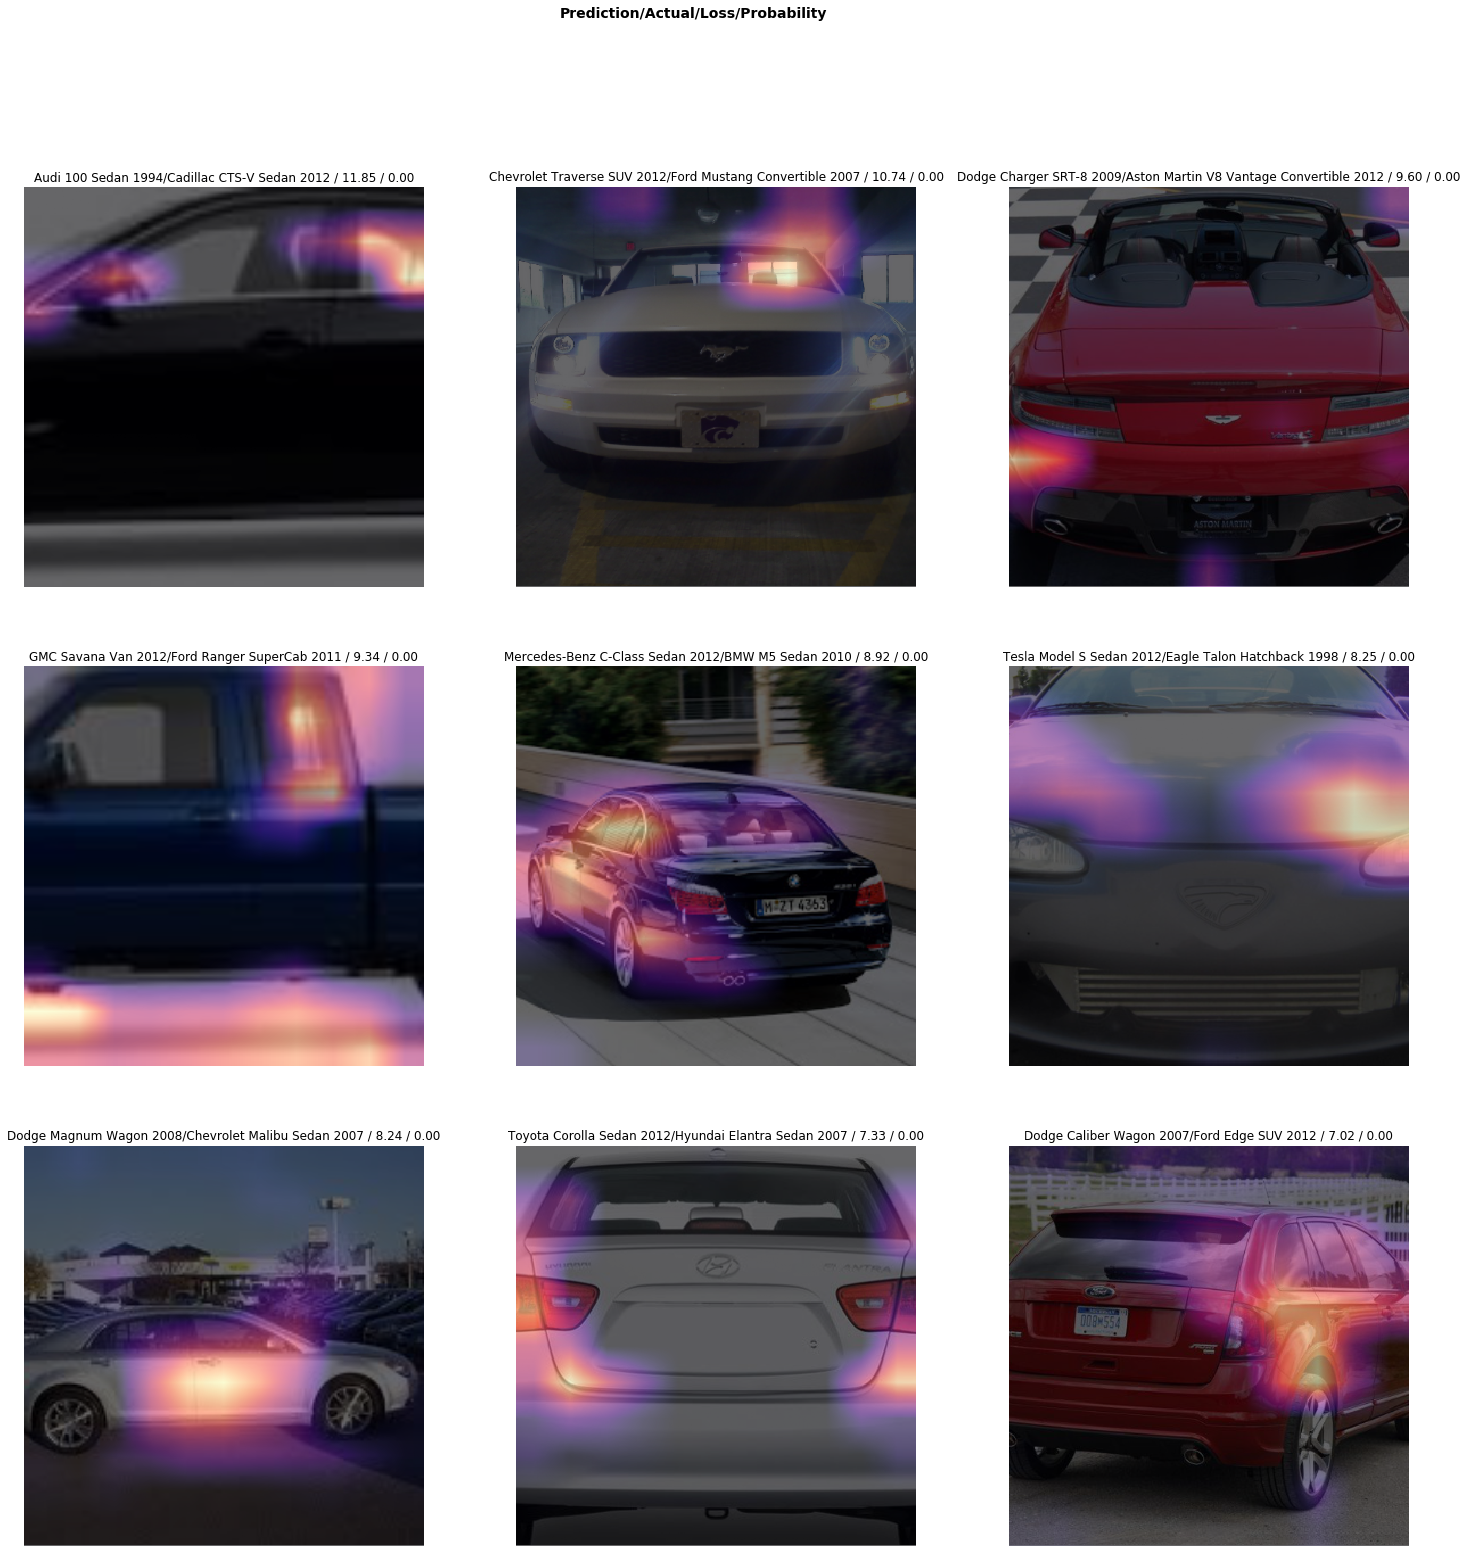

In [114]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, heatmap=True, figsize=(25,25))

## Regularization

__What is regularization?__

> In mathematics, statistics, and computer science, particularly in machine learning and inverse problems, regularization is the process of adding information in order to solve an ill-posed problem or to prevent overfitting.

> Regularization can be motivated as a technique to improve the generalizability of a learned model.

[Wikipedia](https://en.wikipedia.org/wiki/Regularization_(mathematics))

### Bias–variance tradeoff

__Defintion from [Wikipedia](https://en.wikipedia.org/wiki/Bias–variance_tradeoff):__

The bias–variance dilemma or bias–variance problem is the conflict in trying to simultaneously minimize these two sources of error that prevent supervised learning algorithms from generalizing beyond their training set:

- The __bias error__ is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).
- The __variance__ is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (overfitting).

__Graphical Definition__ 

from [Scott Fortmann-Roe](http://scott.fortmann-roe.com/docs/BiasVariance.html)

![Bias Variance](https://miro.medium.com/max/1956/1*CgIdnlB6JK8orFKPXpc7Rg.png)


__Over- and Under-Fitting__

from [Scott Fortmann-Roe](http://scott.fortmann-roe.com/docs/BiasVariance.html)

![Over- and Under-Fitting](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png)

__Example: Linear regression on housing prices__

![Weight Decay](https://github.com/hiromis/notes/raw/master/lesson3/1.png)

We will now discuss some powerful techniques for improving training and avoiding overfitting:

- Early Stopping
- Dropout
- Batch normalization
- Weight Decay
- Data augmentation


### Early Stopping

Early stopping can be viewed as regularization in time. Intuitively, a training procedure like gradient descent will tend to learn more and more complex functions as the number of iterations increases. By regularizing on time, the complexity of the model can be controlled, improving generalization.

[Wikipedia](https://en.wikipedia.org/wiki/Regularization_(mathematics)#Early_stopping)

Our training strategy - fitting a few epochs, fit-one-cycle policy -  already addresses this issue!

![Early Stopping](https://www.oreilly.com/library/view/hands-on-transfer-learning/9781788831307/assets/14c4482c-cab1-4fa7-841f-f1130804fa87.png)

[Image Source](https://www.oreilly.com/library/view/hands-on-transfer-learning/9781788831307/41172567-9482-4cad-ac87-1cfbd46026df.xhtml)

### Dropout

> I went to my bank. The tellers kept changing and I asked one of them why. He said he didn't know but they got moved around a lot. I figured it must be because it would require cooperation between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each example would prevent conspiracies and thus reduce overfitting.

[Geoffrey Hinton](https://www.reddit.com/r/MachineLearning/comments/4w6tsv/ama_we_are_the_google_brain_team_wed_love_to/d6dgyse)

The idea of Dropout: 

___Remove activations at random during training in order to regularize the model___

![Dropout](https://github.com/hiromis/notes/raw/master/lesson6/6.png)

__Dropout at test time__

![Dropout Test Time](https://github.com/hiromis/notes/raw/master/lesson6/7.png)

__The dropout paper is one of the most influential papers of the last ten years with more than 16k citations__

![Dropout Test Time](https://github.com/hiromis/notes/raw/master/lesson6/13.png)

Where do you typically find dropout in state-of-the-art CNN architectures?

In [115]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Batch Normalization

Batch normalization was immediately recognized as high-impact when it came out in 2015. 

![Dropout](https://github.com/hiromis/notes/raw/master/lesson6/14.png)

__The algorithm__

The algorithms is really simple. Batch norm is a layer, and it's going to take in some activations.

1. Find the mean with of the activations - sum divided by the count that is just the mean.
2. Find the variance of the activations - a difference squared divided by the mean is the variance.
3. Normalize - the values minus the mean divided by the standard deviation is the normalized version. It turns out that bit is actually not that important.
4. Scale and shift: Adding vector of biases. $\gamma$ and $\beta$ are learnable parameters, $\beta$ is just a normal bias layer and $\gamma$ is a multiplicative bias layer.

__So what is internal covariate shift?__

Well, it doesn't matter!

___Batch Normalization adjusts the parameterization of a model in order to make the loss surface smoother___

Two recent papers have shown that batch normalization doesn't reduce covariate shift at all. And even if it did, that has nothing to do with why it works.

![Dropout](https://github.com/hiromis/notes/raw/master/lesson6/15.png)

The really important thing to know is you __definitely want to use it.__

In [109]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Weight Decay

One way to penalize complexity would be to add all our parameters (weights) to our loss function. You may have heard of Ridge and Lasso regression, which are simple techniques to reduce model complexity and prevent overfitting.

In Ridge Regression, the cost function is altered by adding a penalty equivalent to square of the magnitude of the coefficients. Ridge Regression uses the L2 regularizer (aka Tikhonov regularization):

<div id="eq:l2"></div>

$$
\begin{equation}
L_2(W) = ||W||_2^2= \sum_{i=1}^{|W|} w_i^2
\end{equation}
$$

Adding L2 regularization to the loss function shrinks the coefficients and helps to reduce the model complexity and multi-collinearity

\begin{equation*}
Final Loss = Loss +  \frac{1}{2} wd * \sum_{i=1}^{|W|} w_i^2
\end{equation*}

In Python code, it looks something like

```python
final_loss = loss + wd * all_weights.pow(2).sum() / 2
```

…where `wd` is the hyper-parameter to set. 

This is also called weight decay, because when applying vanilla SGD it’s equivalent to updating the weight like this:

```python
w = w - lr * w.grad - lr * wd * w
```

In practice, it is nearly always implemented by adding `wd*` to the gradients, rather than actually changing the loss function: we don’t want to add more computations by modifying the loss when there is an easier way.

So why make a distinction between those two concepts if they are the same thing? The answer is that they are only the same thing for vanilla SGD, but as soon as we add momentum, or use a more sophisticated optimizer like Adam, L2 regularization (first equation) and weight decay (second equation) become different. 

So in other words, all weight decay does is it subtracts some constant times the weights every time we do a batch.

- When it's in this form $wd\cdot w^{2}$ where we add the square to the loss function, that's called __L2 regularization__.

- When it's in this form $wd\cdot w$ where we subtract wd times weights from the gradients, that's called __weight decay__.



__Weight decay in fast.ai__

The [default weight decay in fastai](https://docs.fast.ai/basic_train.html#Learner) is 1e-2,  which is a little conservative.

In [135]:
learn.wd

0.01

Often a value of 1e-1 is also reasonable.

In [136]:
learn_wd = cnn_learner(data, models.resnet34, metrics=[accuracy, top_k_accuracy], wd=1e-1)
learn_wd.wd

0.1

### Data Augmentation

> Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. 

[BAIR](https://bair.berkeley.edu/blog/2019/06/07/data_aug/)

__Data Augmentation in Computer Vision__

Data augmentation is perhaps the most important regularization technique when training a model for Computer Vision: instead of feeding the model with the same pictures every time, we do small random transformations (a bit of rotation, zoom, translation, etc...) that don't change what's inside the image (to the human eye) but do change its pixel values. Models trained with data augmentation will then generalize better.

![Data Augmentation](https://bair.berkeley.edu/static/blog/data_aug/basic_aug.png)

[Image Source](https://bair.berkeley.edu/blog/2019/06/07/data_aug/)

__Image transforms__

fastai provides a complete [image transformation library](https://docs.fast.ai/vision.transform.html) written from scratch in PyTorch.

To get a set of transforms with default values that work pretty well in a wide range of tasks, it's often easiest to use `get_transform`. 

In [140]:
data = (src.transform(get_transforms(), size=224)
            .databunch(bs=64)
            .normalize(imagenet_stats))

Depending on the nature of the images in your data, you may want to adjust a few arguments, the most important being:

- `do_flip`: if True the image is randomly flipped (default behavior)
- `flip_vert`: limit the flips to horizontal flips (when False) or to horizontal and vertical flips as well as 90-degrees rotations (when True)

In [150]:
doc(get_transforms)

get_transforms returns a tuple of two lists of transforms: 

- one for the training set and 
- one for the validation set (we don't want to modify the pictures in the validation set, so the second list of transforms is limited to resizing the pictures). 

This can be passed directly to define a DataBunch object which is then associated with a model to begin training.

Note that the defaults for `get_transform` are generally pretty good for regular photos - although here we'll add a bit of extra rotation so it's easier to see the differences.

In [137]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

#### Stanford Cars Example

In [151]:
bs=16
def get_data(size, bs, padding_mode='reflection'):
    return (src
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

__Padding Mode: 'reflection'__

In [152]:
data = get_data(224,bs)

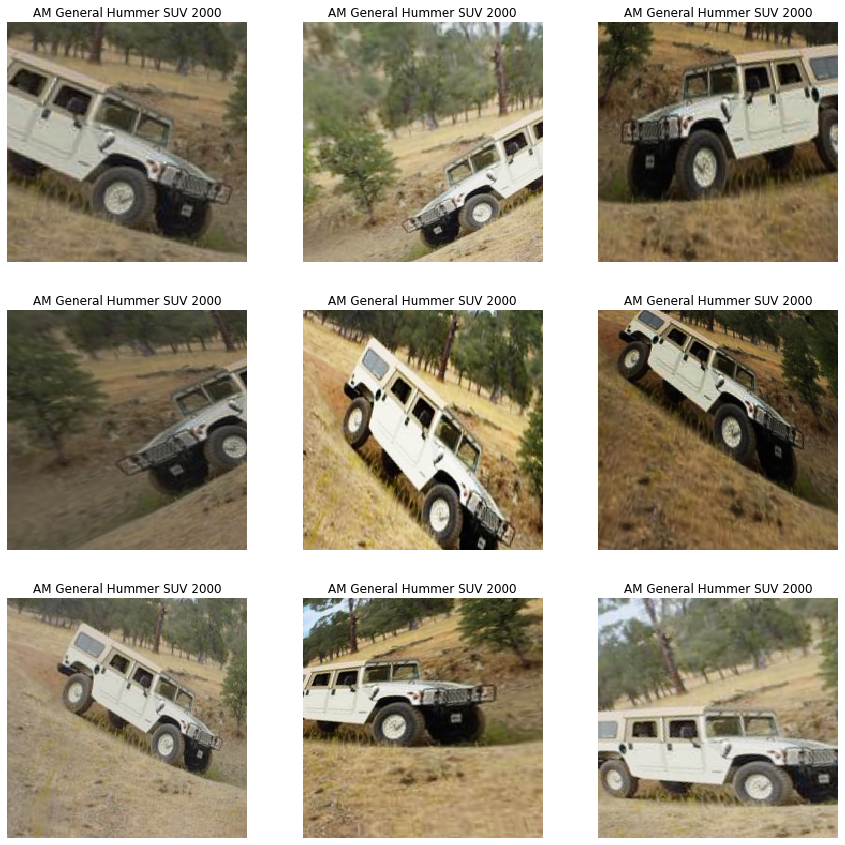

In [153]:
plot_multi(_plot, 3, 3, figsize=(15,15))

__Padding Mode: 'zeros'__ 

In [123]:
data = get_data(224, bs, 'zeros')

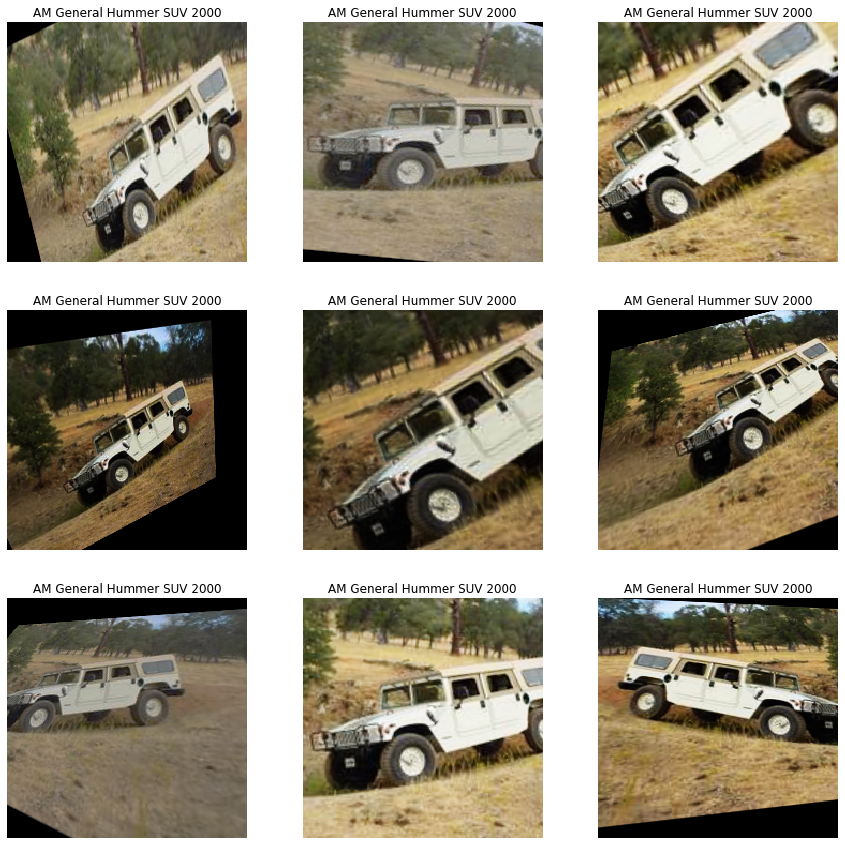

In [125]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(15,15))